# EnergyPlus Parameterization and Sensitivity Analysis for Residential Single Family Homes


## Daniel Xu, Keller Lab

This notebook was created in order to document the workflow and processes of EnergyPlus within Python. This is for my project involving the parameterization of EnergyPlus. Given that EnergyPlus has over 2000 available inputs, more research needs to be done in order to document which parameters are most significant and relevant in home energy modeling and simulations. 

The goal of this project is to run EnergyPlus on a model single family residential home. Some of the inputs will be fixed to default variables. Other variables, such as window thickness, thermostat set-points, etc. will be varied on pre-defined distributions. 

The distributions will be defined as seen in this paper: 
https://www.sciencedirect.com/science/article/abs/pii/S037877881631372X?via=ihub

### Importing necessary libraries

In [1]:
from eppy import modeleditor
from eppy.modeleditor import IDF
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import re

### Changing the working directory 

In [ ]:
os.chdir("/Users/danielxu/Desktop/Dartmouth College/6. Keller Lab/24S/eplus_sensitivity/scripts")
print("Current working directory:", os.getcwd())

### Setting EnergyPlus Input Data Dictionary

In [3]:
idd_file_path = "/Applications/EnergyPlus-24-2-0/Energy+.idd"
IDF.setiddname(idd_file_path)

### Setting a Skeleton IDF File 

This modifiable IDF file is provided by EnergyPlus in its initial download. It provides a mock residential home in Chicago with multiple zones. I will assume that some of the inputs are fixed and others are varied on a distribution. 

Directly from the EnergyPlus documentation: 

"This file does the basic test of an air distribution system in a residential home. A two speed heat pump with a supplmental gas heater provides space heating and cooling. It provides ventilation through the ZoneAirBalance:OutdoorAir model."

In [ ]:
idfname = "/Applications/EnergyPlus-24-2-0/ExampleFiles/SingleFamilyHouse_TwoSpeed_CutoutTemperature.idf"

preidf = IDF(idfname)

# preidf.printidf()

print(preidf.idfobjects['Site:Location'])

## Creating a hot water system in the IDF file

In [5]:
# # Assuming preidf is an initialized IDF object and has the appropriate IDD set

# # Define the water heater
# water_heater = preidf.newidfobject("WATERHEATER:MIXED")
# water_heater.Name = "New Water Heater"
# water_heater.Tank_Volume = "0.15"  # cubic meters
# water_heater.Heater_Maximum_Capacity = "2000"  # watts
# water_heater.Heater_Minimum_Capacity = "1000"  # watts
# water_heater.Setpoint_Temperature_Schedule_Name = "Hot Water Setpoint Temp"
# water_heater.Use_Side_Inlet_Node_Name = "Hot Water Use Inlet Node"
# water_heater.Use_Side_Outlet_Node_Name = "Hot Water Use Outlet Node"
# water_heater.Source_Side_Inlet_Node_Name = "Hot Water Source Inlet Node"
# water_heater.Source_Side_Outlet_Node_Name = "Hot Water Source Outlet Node"
# water_heater.Ambient_Temperature_Indicator = "Zone"
# water_heater.Ambient_Temperature_Zone_Name = "Appropriate Zone Name"  # Specify the correct zone name here
# water_heater.Heater_Fuel_Type = "Electricity"
# water_heater.Heater_Thermal_Efficiency = 0.92  # Fractional efficiency

# # Connect nodes to loops here, ensuring they're part of a PlantLoop or similar
# # Example:
# # Define a new loop or ensure these nodes are included in an existing loop definition

# # Save the IDF file
# preidf.save("/Users/danielxu/Desktop/Dartmouth College/6. Keller Lab/24S/eplus_sensitivity/scripts/skeleton.idf")

### Weather Station Data Retrieval for EnergyPlus Simulations

This project aims to enhance the accuracy of building energy simulations by sourcing precise local weather data. By leveraging the NCEI (National Centers for Environmental Information) API, we are able to identify and retrieve data from the nearest weather station to any specified location. This localized weather data is crucial for feeding into EnergyPlus simulations, ensuring that our building models operate under realistic environmental conditions. The accurate simulation of energy usage and needs based on actual weather data helps in designing more efficient and sustainable buildings.

For more detailed information on how to utilize the NCEI API, including obtaining access tokens and making API requests, please visit the NCEI Web Services Documentation.

In [ ]:
import requests
from datetime import datetime, timedelta

def get_active_weather_stations(api_key, lat, lon):
    base_url = 'https://www.ncei.noaa.gov/cdo-web/api/v2/stations'
    headers = {'token': api_key}
    # Define the date one year ago from today
    one_year_ago = (datetime.now() - timedelta(days=365)).strftime('%Y-%m-%d')

    # Set the request to retrieve more stations for a broader check
    params = {
        'extent': f'{lat-0.05},{lon-0.05},{lat+0.05},{lon+0.05}',
        'limit': '1000',  # Adjust limit as needed
        'sortfield': 'mindate',
        'sortorder': 'desc'
    }

    response = requests.get(base_url, headers=headers, params=params)
    
    if response.status_code != 200:
        print(f"Failed to fetch data: {response.status_code} - {response.text}")
        return []

    try:
        data = response.json()
        active_stations = []
        # Filter stations by checking if the 'maxdate' is within the last year
        for station in data.get('results', []):
            if station['maxdate'] >= one_year_ago:
                active_stations.append(station)
        return active_stations
    except ValueError:
        print("Failed to decode JSON from response.")
        return []

api_key = 'SrgpVmvZhbtZXRSdBgknhaRSQlhTNzBt'
latitude = 41.78  
longitude = -87.75  

active_stations = get_active_weather_stations(api_key, latitude, longitude)
print(f"Found {len(active_stations)} active stations:")
for station in active_stations:
    print(station)


Based on this location, we will then use the diyepw package to create time series weather data. More information about diyepw can be found at: 

https://diyepw.readthedocs.io/en/latest/tutorial.html (PNNL)

In [ ]:
import diyepw

os.chdir("/Users/danielxu/Desktop/Dartmouth College/6. Keller Lab/24S/eplus_sensitivity/scripts/weather data")
print("Current working directory:", os.getcwd())

diyepw.create_amy_epw_files_for_years_and_wmos(
  [2020,2021,2022,2023],
  [725300],
  max_records_to_interpolate=6,
  max_records_to_impute=48,
  max_missing_amy_rows=5,
  allow_downloads=True,
  amy_epw_dir='./'
)

### Editing IDF parameters 



In [ ]:
def update_building_parameters(skeleton_idf_path, idd_file_path, output_idf_dir):
    # Load the EnergyPlus IDD file
    IDF.setiddname(idd_file_path)

    for i in range(100):

        # Load the IDF file
        idf = IDF(skeleton_idf_path)

        # Draw initial values for heating and cooling setpoints
        valid_setpoints = False
        while not valid_setpoints:
            new_heating_setpoint = np.random.uniform(15.0, 22.0)  # Uniform distribution for heating setpoint
            new_cooling_setpoint = np.random.uniform(24.0, 29.0)  # Uniform distribution for cooling setpoint
            # Check that heating setpoint is at least 2 degrees less than cooling setpoint
            if new_cooling_setpoint - new_heating_setpoint >= 5:
                valid_setpoints = True

        # Defining other uniform distributions
        new_people_per_area = np.random.uniform(0.002, 0.060)  # People per m2
        new_flow_per_area = np.random.uniform(0.0, 1.5)  # m3/s/m2
        new_design_level = np.random.uniform(1, 40)  # Watts
        # new_dhw_flow_rate = np.random.uniform(1e-8, 20e-8)  # m3/s

        # Update building parameters
        people_object = idf.getobject('PEOPLE', 'LIVING ZONE People')
        people_object.People_per_Floor_Area = new_people_per_area
        print(f"Updated {people_object.Name} with People per Floor Area = {new_people_per_area} pp/m2")

        infiltration_object = idf.getobject('ZONEINFILTRATION:DESIGNFLOWRATE', 'LIVING ZONE Infil 1')
        infiltration_object.Design_Flow_Rate_Calculation_Method = 'Flow/Area'
        # infiltration_object.Design_Flow_Rate = new_flow_per_area
        infiltration_object.Flow_Rate_per_Floor_Area = new_flow_per_area
        print(f"Updated {infiltration_object.Name} with Flow per Zone Floor Area = {new_flow_per_area} m3/s-m2")

        equipment_object = idf.getobject('ELECTRICEQUIPMENT', 'LIVING ZONE ElecEq')
        equipment_object.Design_Level = new_design_level
        print(f"Updated {equipment_object.Name} with Design Level = {new_design_level} W")

        # water_heater = idf.getobject('WATERHEATER:MIXED', 'New Water Heater')
        # water_heater.Use_Side_Design_Flow_Rate = new_dhw_flow_rate
        # print(f"Updated {water_heater.Name} with Domestic Hot Water Flow Rate = {new_dhw_flow_rate} m3/s")

        # Update the heating and cooling setpoint schedules
        heating_schedule = idf.getobject('SCHEDULE:COMPACT', 'Dual Heating Setpoints')
        heating_schedule.fieldvalues[6] = str(new_heating_setpoint)
        print(f"Updated Heating Setpoint to {new_heating_setpoint}°C")

        cooling_schedule = idf.getobject('SCHEDULE:COMPACT', 'Dual Cooling Setpoints')
        cooling_schedule.fieldvalues[6] = str(new_cooling_setpoint)
        print(f"Updated Cooling Setpoint to {new_cooling_setpoint}°C")

        # Save the modified IDF file with a unique name
        output_file_path = f"{output_idf_dir}/randomized_{i+1}.idf"
        idf.save(output_file_path)
        print(f"File saved: {output_file_path}")

# Paths to your IDF and IDD files
idd_file_path = "/Applications/EnergyPlus-24-2-0/Energy+.idd"
output_idf_dir = "/Users/danielxu/Desktop/Dartmouth College/6. Keller Lab/24S/eplus_sensitivity/scripts/randomized idfs"
# skeleton_idf_path = "/Users/danielxu/Desktop/Dartmouth College/6. Keller Lab/24S/eplus_sensitivity/scripts/skeleton.idf"
skeleton_idf_path = idfname

# Execute the function
update_building_parameters(skeleton_idf_path, idd_file_path, output_idf_dir)

In [9]:
# import re

# def update_building_parameters(skeleton_idf_path, idd_file_path, output_idf_path):
#     # Load the EnergyPlus IDD file
#     IDF.setiddname(idd_file_path)

#     for i in range(100):

#         # Load the IDF file
#         idf = IDF(skeleton_idf_path)

#         # Defining uniform distributions 
#         new_people_per_area = np.random.uniform(0.002, 0.060)  # People per m2
#         new_flow_per_area = np.random.uniform(0.0, 1.5)  # m3/s/m2
#         new_design_level = np.random.uniform(1, 40)  # Watts
#         new_dhw_flow_rate = np.random.uniform(1e-8, 20e-8)  # m3/s
#         new_heating_setpoint = np.random.uniform(15.0, 22.0)  # Uniform distribution for heating setpoint
#         new_cooling_setpoint = np.random.uniform(24.0, 29.0)  # Uniform distribution for cooling setpoint

#         # Retrieve the specific PEOPLE object
#         people_object = idf.getobject('PEOPLE', 'LIVING ZONE People')
#         people_object.People_per_Floor_Area = new_people_per_area
#         print(f"Updated {people_object.Name} with People per Floor Area = {new_people_per_area} pp/m2")

#         # Retrieve the specific ZoneInfiltration:DesignFlowRate object
#         infiltration_object = idf.getobject('ZONEINFILTRATION:DESIGNFLOWRATE', 'LIVING ZONE Infil 1')
#         infiltration_object.Design_Flow_Rate_Calculation_Method = 'Flow/Area'
#         infiltration_object.Design_Flow_Rate = new_flow_per_area
#         print(f"Updated {infiltration_object.Name} with Flow per Zone Floor Area = {new_flow_per_area} m3/s-m2")

#         # Update Equipment Power Density
#         equipment_object = idf.getobject('ELECTRICEQUIPMENT', 'LIVING ZONE ElecEq')
#         equipment_object.Design_Level = new_design_level
#         print(f"Updated {equipment_object.Name} with Design Level = {new_design_level} W")

#         # Retrieve and update the WATERHEATER:MIXED object
#         water_heater = idf.getobject('WATERHEATER:MIXED', 'New Water Heater')
#         water_heater.Use_Side_Design_Flow_Rate = new_dhw_flow_rate
#         print(f"Updated {water_heater.Name} with Domestic Hot Water Flow Rate = {new_dhw_flow_rate} m3/s")

#         # Retrieve and update the heating and cooling setpoint schedules
#         heating_schedule = idf.getobject('SCHEDULE:COMPACT', 'Dual Heating Setpoints')
#         heating_schedule.fieldvalues[6] = str(new_heating_setpoint)
#         print(f"Updated Heating Setpoint to {new_heating_setpoint}°C")

#         cooling_schedule = idf.getobject('SCHEDULE:COMPACT', 'Dual Cooling Setpoints')
#         cooling_schedule.fieldvalues[6] = str(new_cooling_setpoint)
#         print(f"Updated Cooling Setpoint to {new_cooling_setpoint}°C")

#         # Save the modified IDF file with a unique name
#         output_file_path = f"{output_idf_dir}/randomized_{i+1}.idf"
#         idf.save(output_file_path)
#         print(f"File saved: {output_file_path}")

# # Paths to your IDF and IDD files
# skeleton_idf_path = "/Users/danielxu/Desktop/Dartmouth College/5. Keller Lab/24S/eplus_sensitivity/scripts/skeleton.idf"
# output_idf_dir = "/Users/danielxu/Desktop/Dartmouth College/5. Keller Lab/24S/eplus_sensitivity/scripts/randomized idfs"

# # Execute the function
# update_building_parameters(skeleton_idf_path, idd_file_path, output_idf_dir)

### Running the simulation and outputting the results

In [ ]:
os.chdir("/Users/danielxu/Desktop/Dartmouth College/6. Keller Lab/24S/eplus_sensitivity/scripts/output")
print("Current working directory:", os.getcwd())

In [11]:
# Paths to your directories and files
idf_dir = "/Users/danielxu/Desktop/Dartmouth College/6. Keller Lab/24S/eplus_sensitivity/scripts/randomized idfs"
weather_file = "/Applications/EnergyPlus-24-2-0/WeatherData/USA_IL_Chicago-OHare.Intl.AP.725300_TMY3.epw"
idd_file_path = "/Applications/EnergyPlus-24-2-0/Energy+.idd"
output_base_dir = "/Users/danielxu/Desktop/Dartmouth College/6. Keller Lab/24S/eplus_sensitivity/scripts/output"

In [ ]:
import os
import shutil
from eppy import modeleditor
from eppy.modeleditor import IDF
import subprocess

def run_energyplus_simulation(idf_dir, weather_file, idd_file_path, output_base_dir):
    # Set the IDD file path
    IDF.setiddname(idd_file_path)
    
    # Get the list of IDF files
    idf_files = [f for f in os.listdir(idf_dir) if f.endswith('.idf')]
    
    for idf_file in idf_files:
        # Define paths
        idf_path = os.path.join(idf_dir, idf_file)
        idf_output_dir = os.path.join(output_base_dir, os.path.splitext(idf_file)[0])
        
        # Create output directory if it doesn't exist
        os.makedirs(idf_output_dir, exist_ok=True)
        
        # Load the IDF file
        idf = IDF(idf_path)
        
        # Save a copy of the IDF file in the output directory
        idf_copy_path = os.path.join(idf_output_dir, os.path.basename(idf_path))
        idf.save(idf_copy_path)
        
        # Run the EnergyPlus simulation
        subprocess.run([
            'energyplus', 
            '--weather', weather_file, 
            '--output-directory', idf_output_dir, 
            '--idd', idd_file_path, 
            '--annual',
            '--readvars',
            idf_copy_path
        ])

# Example usage
idf_dir = "/Users/danielxu/Desktop/Dartmouth College/6. Keller Lab/24S/eplus_sensitivity/scripts/randomized idfs"
weather_file = "/Applications/EnergyPlus-24-2-0/WeatherData/USA_IL_Chicago-OHare.Intl.AP.725300_TMY3.epw"
idd_file_path = "/Applications/EnergyPlus-24-2-0/Energy+.idd"
output_base_dir = "/Users/danielxu/Desktop/Dartmouth College/6. Keller Lab/24S/eplus_sensitivity/scripts/output"

run_energyplus_simulation(idf_dir, weather_file, idd_file_path, output_base_dir)

### Interpreting Results

In [32]:
# Path to the directory containing all the "randomized_x" output folders
output_base_dir = "/Users/danielxu/Desktop/Dartmouth College/6. Keller Lab/24S/eplus_sensitivity/scripts/output"

all_data_frames = []

for i in range(1, 101):
    folder_name = f"randomized_{i}"
    file_path = os.path.join(output_base_dir, folder_name, "eplusmtr.csv")
    
    # Check if the file exists
    if os.path.isfile(file_path):
        temp_df = pd.read_csv(file_path)
        # Tag this data with a Simulation ID
        temp_df["Simulation_ID"] = i
        
        all_data_frames.append(temp_df)
    else:
        print(f"File not found: {file_path}")

# Combine everything into one DataFrame
combined_df = pd.concat(all_data_frames, ignore_index=True)

# Print the first few rows to verify
print(combined_df.head())

# Print some info about the final DataFrame
print("Combined DataFrame shape:", combined_df.shape)

  Date/Time  Electricity:Facility [J](Monthly)  \
0   January                       9.822518e+09   
1  February                       9.356073e+09   
2     March                       1.101171e+10   
3     April                       1.026072e+10   
4       May                       1.034695e+10   

   Electricity:Building [J](Monthly)  InteriorLights:Electricity [J](Monthly)  \
0                       9.834676e+08                              970200000.0   
1                       8.596970e+08                              848160000.0   
2                       9.095939e+08                              897480000.0   
3                       9.422108e+08                              929520000.0   
4                       9.837819e+08                              970200000.0   

   Electricity:HVAC [J](Monthly)  NaturalGas:Facility [J](Monthly)  \
0                   8.839050e+09                      1.791610e+11   
1                   8.496376e+09                      1.585827e+11   
2 

In [33]:
# Path to the directory where you want to save the CSV
analysis_dir = '/Users/danielxu/Desktop/Dartmouth College/6. Keller Lab/24S/eplus_sensitivity/analysis'

# Create the directory if it does not exist
os.makedirs(analysis_dir, exist_ok=True)

# Create a file path for the output CSV
output_csv_path = os.path.join(analysis_dir, 'combined_sims.csv')

combined_df["Electricity:Facility [J](Monthly)"] = pd.to_numeric(
    combined_df["Electricity:Facility [J](Monthly)"], 
    errors="coerce"
)

# Write the combined DataFrame to CSV
combined_df.to_csv(output_csv_path, index=False)

print(f"Data has been written to: {output_csv_path}")

Data has been written to: /Users/danielxu/Desktop/Dartmouth College/6. Keller Lab/24S/eplus_sensitivity/analysis/combined_sims.csv


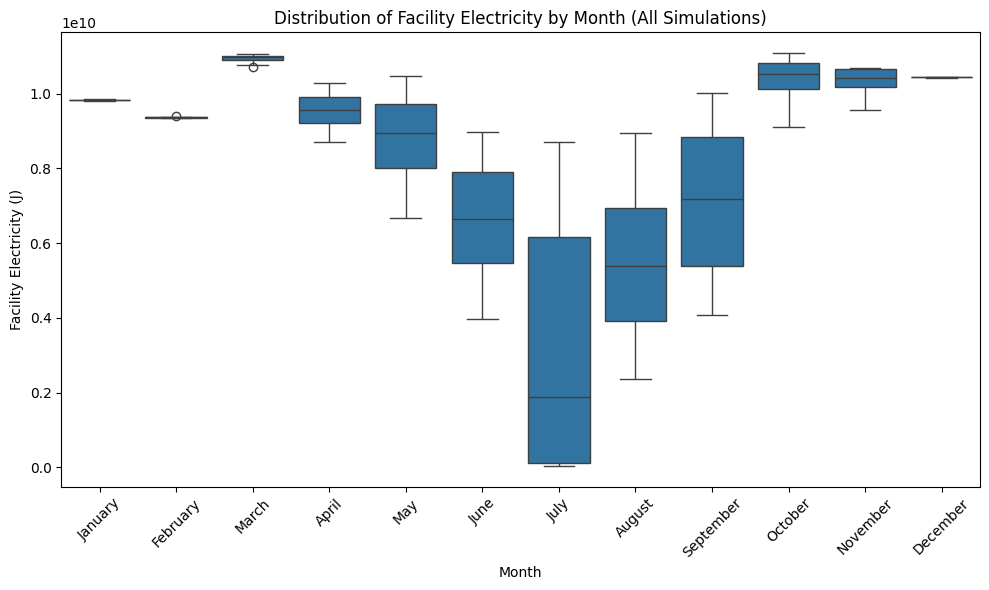

<Figure size 1000x600 with 0 Axes>

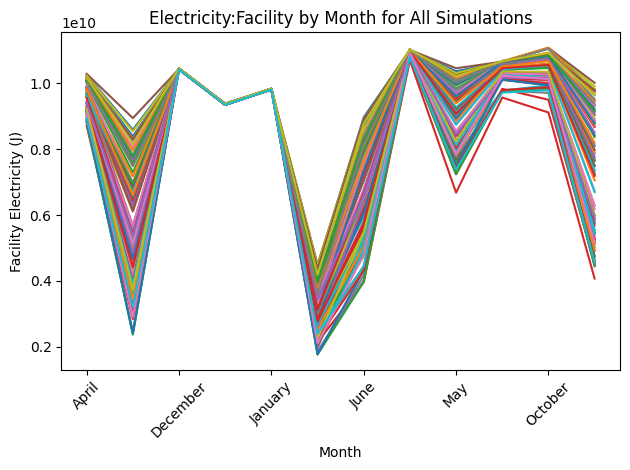

In [34]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

# Example path to your combined CSV file
analysis_dir = '/Users/danielxu/Desktop/Dartmouth College/6. Keller Lab/24S/eplus_sensitivity/analysis'
csv_path = os.path.join(analysis_dir, 'combined_sims.csv')

# Load the data
df = pd.read_csv(csv_path)

# -----------------------------------------------------------------------------
# 1) Box Plot - Distribution of Facility Electricity by Month Across Simulations
# -----------------------------------------------------------------------------

plt.figure(figsize=(10, 6))
sns.boxplot(x='Date/Time', y='Electricity:Facility [J](Monthly)', data=df)
plt.title('Distribution of Facility Electricity by Month (All Simulations)')
plt.xlabel('Month')
plt.ylabel('Facility Electricity (J)')
plt.xticks(rotation=45)  # Rotate month labels if needed
plt.tight_layout()
plt.show()

# -----------------------------------------------------------------------------
# 2) Line Plot - Each Simulation’s Monthly Electricity Use
# -----------------------------------------------------------------------------
# This approach transforms the DataFrame into wide format, where each Simulation
# has a row, and each Month is a column. Then it plots all simulations as lines.

# Pivot so we have one row per Simulation_ID and one column per Month
pivoted = df.pivot_table(
    index='Simulation_ID',
    columns='Date/Time',
    values='Electricity:Facility [J](Monthly)'
)

plt.figure(figsize=(10, 6))
pivoted.T.plot(legend=False)  # Transpose so Months are on the x-axis
plt.title('Electricity:Facility by Month for All Simulations')
plt.xlabel('Month')
plt.ylabel('Facility Electricity (J)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

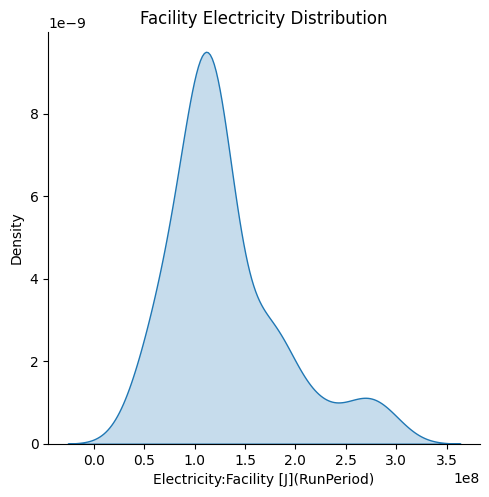

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

jan_df = df[df["Date/Time"] == "July"]
if not jan_df.empty:
    sns.displot(
        data=jan_df,
        x="Electricity:Facility [J](RunPeriod)",
        kind="kde",
        fill=True
    )
    plt.title("Facility Electricity Distribution")
    plt.show()
else:
    print("No data found for January.")

In [ ]:
import esoreader

PATH_TO_ESO = '/Users/danielxu/Desktop/Dartmouth College/6. Keller Lab/24S/eplus_sensitivity/scripts/output/randomized_92/eplusout.eso'
eso = esoreader.read_from_path(PATH_TO_ESO)

variables = eso.dd.find_variable('Energy')

print(variables) 

In [ ]:
index = eso.dd.index[('TimeStep,REPORTSCH', 'ACDXCOIL 1', 'Cooling Coil Total Cooling Energy')]

data = eso.data[index]

print(data)
# print(variables)


In [ ]:
import pandas as pd
from datetime import datetime, timedelta

# Define the start date and the time step duration (10 minutes for 6 steps per hour)
start_date = datetime(2024, 1, 1, 0, 0)
time_step_duration = timedelta(minutes=10)

# Define the schedule
schedule = [
    (datetime(2024, 1, 1), datetime(2024, 1, 20), 0.0),
    (datetime(2024, 1, 21), datetime(2024, 1, 21), 1.0),
    (datetime(2024, 1, 22), datetime(2024, 7, 20), 0.0),
    (datetime(2024, 7, 21), datetime(2024, 7, 21), 1.0),
    (datetime(2024, 7, 22), datetime(2024, 12, 31), 0.0),
]

# Generate a list of timestamps and corresponding schedule values
timestamps = []
schedule_values = []
current_time = start_date

for energy_value in data:
    # Find the applicable schedule value for the current time
    schedule_value = next(value for start, end, value in schedule if start <= current_time <= end)
    timestamps.append(current_time)
    schedule_values.append(schedule_value)
    current_time += time_step_duration

# Create the DataFrame
df = pd.DataFrame({
    'Timestamp': timestamps,
    'Schedule_Value': schedule_values,
    'Energy_Use': data
})

# Show the first few rows of the DataFrame
print(df.head())

# Save the DataFrame to a CSV file (optional)
df.to_csv('aligned_energy_use_data.csv', index=False)